In [62]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [15]:
# build the dataset
import random
block_size = 3  # context length: how many characters do we take to predict the next one?


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / \
    (n_embd * block_size**0.5)  # 0.2 n_embd = 10 and block size is 3
b1 = torch.randn(n_hidden,                        generator=g) * .01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [102]:
hpreact.shape

torch.Size([32, 200])

In [108]:
hpreact.mean(0, keepdim=True)

tensor([[-9.0047e-01, -6.1440e-04, -1.1101e+00,  2.3400e+00,  2.9763e-01,
         -1.5884e-01,  1.5965e-01, -2.6204e+00,  1.2253e+00,  9.9385e-01,
          3.5851e-01, -8.2009e-01,  2.8643e-01,  4.1431e-01, -1.6773e-02,
         -2.3592e-03,  1.2345e+00, -7.8137e-01,  4.3292e-01,  3.5569e+00,
          5.8309e-01,  4.4639e-01,  1.3874e-03,  4.4913e-01,  9.9279e-01,
          5.1355e-01,  9.6173e-03,  3.8656e-03, -3.0698e-01,  1.0578e+00,
          1.6215e-01, -9.1607e-03,  7.2573e-01, -1.0559e-03,  1.7400e-03,
         -3.0137e+00,  1.5076e+00, -1.7997e-02, -8.5241e-01,  8.9607e-03,
          9.0096e-01, -3.2211e-01, -1.4548e+00, -8.5445e-03,  2.0900e-02,
         -7.6055e-03, -2.1003e-02, -1.3167e+00,  1.4109e-02,  3.5738e-03,
         -1.4693e-02, -1.5231e-02,  2.4293e+00, -6.1013e-01, -9.4543e-02,
         -4.8605e-01,  1.6630e-02,  9.9723e-01,  2.0510e+00, -1.2255e+00,
          4.0751e-01,  1.3876e+00,  9.2678e-03,  1.7459e+00,  1.4798e+00,
          8.2408e-01,  1.0897e+00,  3.

In [ ]:
hpreact.mean

In [110]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch x,y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    u = hpreact.mean(0, keepdim=True)  # mini-batch mean
    hpreact = (hpreact - u)/hpreact.std(0, keepdim=True)
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 2.4901
  10000/ 200000: 2.6460
  20000/ 200000: 2.0737
  30000/ 200000: 2.1142
  40000/ 200000: 1.9422
  50000/ 200000: 2.0652
  60000/ 200000: 2.2391
  70000/ 200000: 2.2984
  80000/ 200000: 2.0452
  90000/ 200000: 1.9703
 100000/ 200000: 2.4033
 110000/ 200000: 2.2639
 120000/ 200000: 1.5911
 130000/ 200000: 1.5765
 140000/ 200000: 2.1051
 150000/ 200000: 2.1070
 160000/ 200000: 2.0364
 170000/ 200000: 2.1525
 180000/ 200000: 2.1446
 190000/ 200000: 1.9931


In [111]:
logits[0]

tensor([-1.7727,  0.8293,  1.2401, -0.8536,  1.5674,  0.0452, -1.6381, -1.0467,
         0.1278,  0.3880, -1.3042, -0.2424,  2.2164,  1.6293,  2.3182, -2.2970,
        -1.3909, -2.6268,  1.5071,  0.9348,  0.4435,  0.2198,  1.2548, -2.3606,
        -1.0657,  1.0291,  0.3459], grad_fn=<SelectBackward0>)

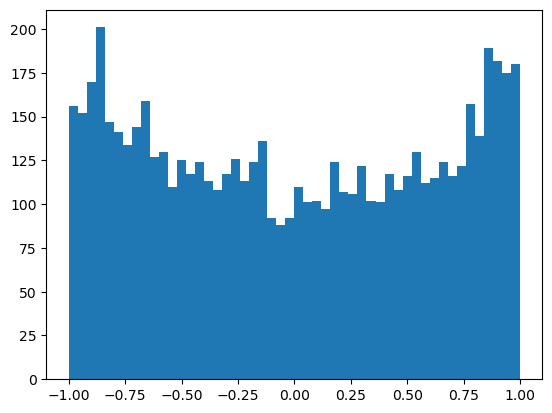

In [112]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

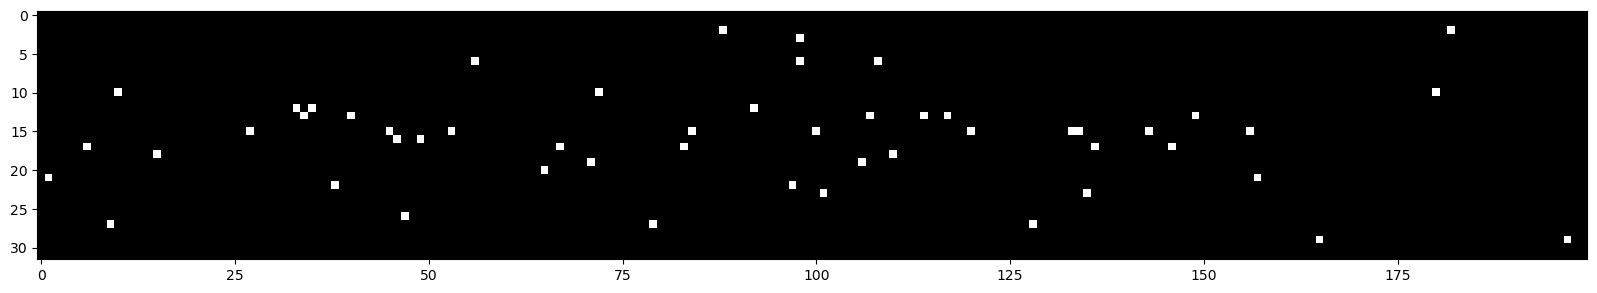

In [113]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.show()

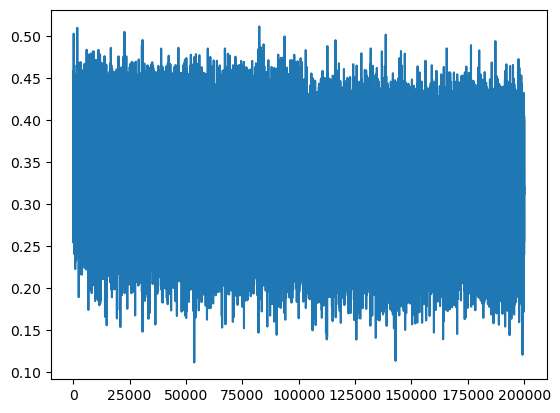

In [114]:
plt.plot(lossi)
plt.show()

In [115]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  # + b1
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.4934988021850586
val 2.597463846206665


tensor(0.0100) tensor(0.9933)
tensor(-0.0005) tensor(0.9681)


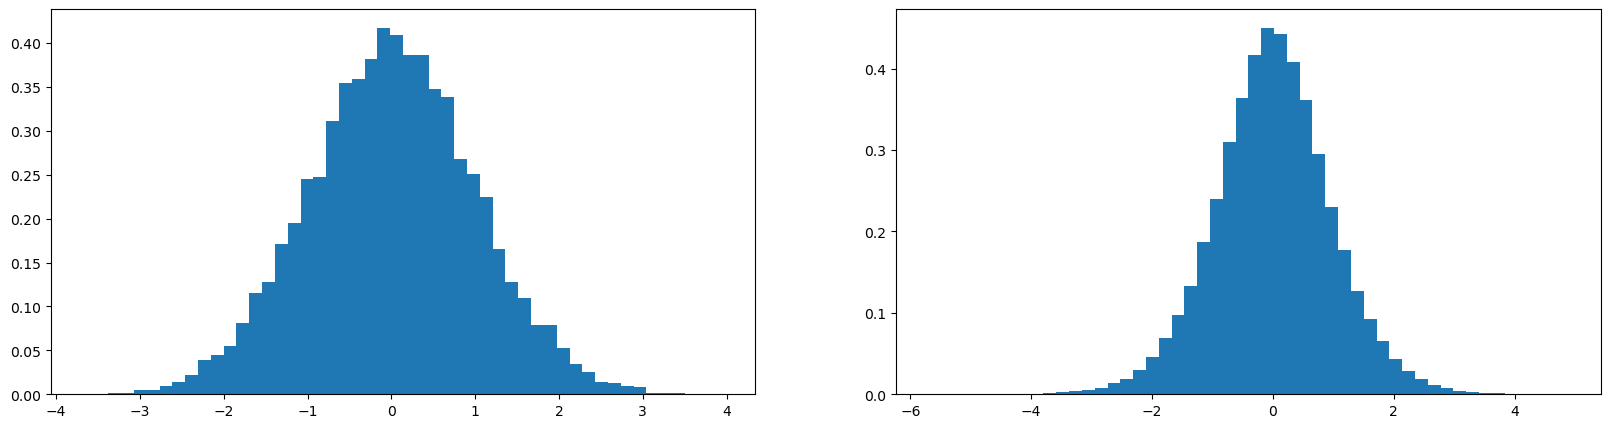

In [116]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

In [117]:
-torch.tensor(1/27).log()

tensor(3.2958)